## Classification

In Classification problems we are trying to find the category, the name of the class that the input object is an instacne.

In `Binary Classifiaction` Problems we are trying to predict the category of an object out of two categories.

## Importing the Modules we will need


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import make_circles            # Its a Binary Classification
from sklearn.model_selection import train_test_split # For splitting the Dataset into Training and Test sets
import pandas as pd
import matplotlib.pyplot as plt

from torch.utils.data import random_split, TensorDataset

## Defining the default Device

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Creating the Dataset

In [3]:
# First we need to define the number of samples we want
n_samples = 1_000

# Creating the features and the labels
x, y = make_circles(n_samples, noise=0.03, random_state=9) # x, y are numpy arrays, `random_state` is the seed and noise the `randomness`

print(len(x), x.shape)
print(len(y), y.shape)

1000 (1000, 2)
1000 (1000,)


## Understanding the Dataset

### Printing Method
Not very usefull in that dataset, but we did manage to get that _y_ take only two values: 0 and 1

In [4]:
print(f"First 5 samples of x:\n{x[:5]}")
print(f"First 5 samples of y:\n{y[:5]}")

First 5 samples of x:
[[ 0.9700792   0.02050779]
 [ 0.00342194 -0.80475568]
 [ 0.78394958  0.66784714]
 [ 0.94256577 -0.04982763]
 [ 0.08434282  0.7617769 ]]
First 5 samples of y:
[0 1 0 0 1]


### Pandas Data Frames
Not very usefull, but it is a lot better from just printing the Dataset

In [5]:
circles = pd.DataFrame({"x1": x[:, 0], "x2": x[:, 1], "y": y})
circles.head(10)

,x1,x2,y
0,0.970079,0.020508,0
1,0.003422,-0.804756,1
2,0.783950,0.667847,0
3,0.942566,-0.049828,0
4,0.084343,0.761777,1
5,0.816294,0.507213,0
6,-0.815656,0.593474,0
7,-0.414946,0.658867,1
8,0.143199,0.711816,1
9,-0.812615,-0.593902,0


### Plotting the Dataset

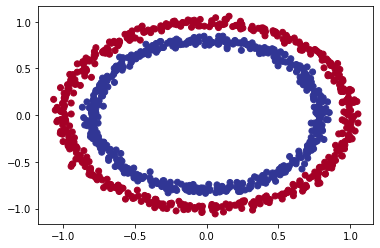

In [6]:
# The first 2 parameters are the point of the axis
# The 3rd parameter is the base of the seperation (those points are going to be classified by the label y)
# The last parameter is the coloring code (can find more in 'plt.cm')
plt.scatter(x[:, 0], x[:, 1], c=y, cmap=plt.cm.RdYlBu)
plt.show()

### What that Dataset represents?
This Dataset respresents point in the plane cordinate system that form 2 cycles. Each point is either classified in cycle 0 or in cycle 1

## Converting the Data into Tensors

In [7]:
# We are using 'type()' because by default the dtype of a numpy array is `float64`
x = torch.from_numpy(x).type(torch.float32)
y = torch.from_numpy(y).type(torch.float32)

## Splitting the Data into Training and Test sets

### 1st Way (using Pytorch)

In [8]:
train_size = int(len(x) * 0.8)

train_ds, test_ds = random_split(TensorDataset(x, y), [train_size, len(x) - train_size])

### 2nd Way (using sklearn)

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2) 

## Transforming the y_labels

In [10]:
# y_train and y_test has shape: [n], but we need them to [n, 1]

y_train = y_train.reshape(len(y_train), 1)
y_test = y_test.reshape(len(y_test), 1)

print(y_train[:5])

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.]])


## Moving the Training and Test sets to Device

In [11]:
x_train = x_train.to(device)
y_train = y_train.to(device)

x_test = x_test.to(device)
y_test = y_test.to(device)

## Building the Model Class

In [12]:
class CirleClassification(nn.Module):
    def __init__(self):
        super().__init__()

        # Creating also a `Hidden` layer
        self.linear1 = nn.Linear(in_features=2, out_features=5)
        self.linear2 = nn.Linear(in_features=5, out_features=1)       

    def forward(self, x):
        return self.linear2(self.linear1(x))

## Initialize our Model and Send it to Device

In [13]:
model = CirleClassification().to(device)

print(next(model.parameters()).device)

cpu


In [14]:
# The same model can be created using:
model = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

print(next(model.parameters()).device)

# In more complex problems we are using 'nn.Sequential()' inside the 'forward()' method

cpu


## Visuzlize our Model

We can `visualize` out model in: https://playground.tensorflow.org/

## Making some Predictions

In [15]:
with torch.inference_mode():
    untrained_preds = model(x_train)

    print(f"Length of Prediction: {len(untrained_preds)}")
    print(f"First 5 Predictions:\n{untrained_preds[:5]}")

# Note that the predictions are floating point numbers

Length of Prediction: 800
First 5 Predictions:
tensor([[-0.4236],
        [-0.4915],
        [-0.8745],
        [-1.0143],
        [-1.0531]])


## Seting up a Loss Function

For Classification Problems the most common Loss Function is `cross entropy`

In [16]:
# We are going to use a variation of cross entropy (for binary classification problems)
loss_fn = nn.BCEWithLogitsLoss() # Contains sigmoid activation function

# We could use just 'BCELoss()' but in that case the inputs should have gone through the sigmoid function
# It is numericly more stable that using 'BCELoss()' and sigmoid separately

## Setting up an Optimize

In [17]:
optimizer = optim.SGD(model.parameters(), lr=0.1)

## Creating an Evaluation Metric

In [18]:
# As an evaluating metric we are going to use `accuracy`: the percentage of right predictions to the number of predictions
def accuracy_fn(labels, preds):
    return (torch.sum(labels == preds).item() / len(labels)) * 100

## Converting Model output to Labels

Another aspect we need to handle is how to convert the **logits** meaning the raw ouput of the model to **probabilities** and right after to **labels**.

We can convert the **logits** into **probabilities** by using the **sigmoid** function in `Binary Classifiaction` problems and **softmax** in `Multiple Classification` problems.

Then we can convert the **probabilities** into **labels** by either `rounding` of taking the `argmax` of the probabilities.

This process is nessesary because we can only pass into the loss function data in the same format as the actual labels.

In [19]:
# First we will see the first 5 output lables of the model
model.eval()
with torch.inference_mode():
    logits = model(x_test)

print(logits[:5])

tensor([[-1.2530],
        [-0.6243],
        [-0.6842],
        [-0.3799],
        [-1.0257]])


In [20]:
# Applying sigmoid activation function to logits (we cannot skip that step)
probabilities = torch.sigmoid(logits)

print(probabilities[:5])

tensor([[0.2222],
        [0.3488],
        [0.3353],
        [0.4062],
        [0.2639]])


In [21]:
# Converting the probabilities into labels
labels = probabilities.round()

print(labels[:5])

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]])


In [22]:
# We can write the process into one line
with torch.inference_mode():
    l = torch.round(torch.sigmoid(model(x_test)))

print(l[:5] == labels[:5])

tensor([[True],
        [True],
        [True],
        [True],
        [True]])


## Creating the Training and Evaluating Loop

In [68]:
def fit(model, epochs, x_train, y_train, x_test, y_test, loss_fn, accuracy_fn, optimizer, print_every):

    losses = []
    accs = []
    
    for epoch in range(1, epochs + 1):
        ### Training
        model.train()

        # Forward pass
        preds_logits = model(x_train)

        # Calculate Loss (because we use BCEWithLogitsLoss() we don't need to convert the logits into labels)
        loss = loss_fn(preds_logits, y_train)

        # Making the gradients zero
        optimizer.zero_grad()

        # Calculate the gradients
        loss.backward()

        # Adjusting the parameters
        optimizer.step()


        ### Testing
        model.eval()
        with torch.inference_mode():
            # Forward pass
            test_logits = model(x_test)

            # Calulate loss and acc
            loss = loss_fn(test_logits, y_test)
            acc = accuracy_fn(y_test, torch.round(torch.sigmoid(test_logits)))

            losses.append(loss)
            accs.append(acc)
        

        ## Storing the process
        if epoch % print_every == 0:
            print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc(%): {acc:.2f}%")

    return losses, accs

## Training the Model

In [69]:
losses1, accs1 = fit(model, 100, x_train, y_train, x_test, y_test, loss_fn, accuracy_fn, optimizer, 10)

Epoch: 10 | Loss: 0.69369 | Acc(%): 47.00%
Epoch: 20 | Loss: 0.69369 | Acc(%): 47.00%
Epoch: 30 | Loss: 0.69369 | Acc(%): 47.00%
Epoch: 40 | Loss: 0.69369 | Acc(%): 47.00%
Epoch: 50 | Loss: 0.69369 | Acc(%): 47.00%
Epoch: 60 | Loss: 0.69369 | Acc(%): 47.00%
Epoch: 70 | Loss: 0.69369 | Acc(%): 47.00%
Epoch: 80 | Loss: 0.69369 | Acc(%): 47.00%
Epoch: 90 | Loss: 0.69369 | Acc(%): 47.00%
Epoch: 100 | Loss: 0.69369 | Acc(%): 47.00%


## What is Happening?

Our model isn't Learning, lets see why is that.

### Prediction and Evaluating Visual

In [70]:
# To see what happend we will use some functions that can be found here:
#   https://github.com/mrdbourke/pytorch-deep-learning/blob/main/helper_functions.py

# First we need to download the file
import requests
from pathlib import Path

if not Path("helper_functions.py").is_file():
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

### Importing the Function

In [71]:
from helper_functions import plot_decision_boundary

### Plotting the Decision Boundary of the Model

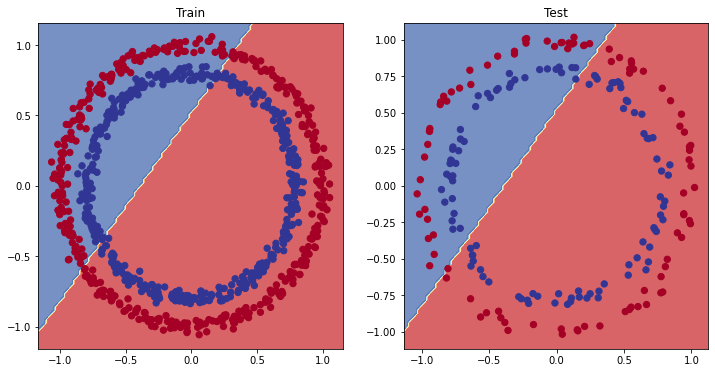

In [72]:
plt.figure(figsize=(12, 6)) # Making the figure larger
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, x_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, x_test, y_test)

So we can see that the model is trying to split the dataset (the circles) using a flat `line`, which is impossible with that topology.

So we need a `non-linear` expression, so the model could adjust to the dataset.

There are other ways of increasing the quality of the mode:
1. Adding more epochs.
2. Adding more hidden layers (etc. from 1 to 100, but multiple of 8 are good).
3. Adding more hidden units (etc. from 5 to 100).
4. Changing the Loss Function.
5. Changing the Optimizer.

But those ways are not going to solve our problem.

To achive a **non-linear** relationship after each layer we add a **non-linear** activation function, such as `ReLU`.

Generally when performing _Machine Learning_ experiments we create different models that impoves only in one or two ways. To keep track the process.

## Creating an Impoved Model

In [74]:
class Improved_Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(in_features=2, out_features=16)
        self.linear2 = nn.Linear(in_features=16, out_features=128)
        self.linear3 = nn.Linear(in_features=128, out_features=16)
        self.linear4 = nn.Linear(in_features=16, out_features=1)
        self.relu = nn.ReLU() # Creating the ReLU object

    def forward(self, x):
        # I didn't use assignment to decrease the time a single call takes
        return self.linear4(self.relu(self.linear3(self.relu(self.linear2(self.relu(self.linear1(x)))))))

## Initialize the Imporved Model

In [75]:
im_model = Improved_Model().to(device)

print(im_model)

Improved_Model(
  (linear1): Linear(in_features=2, out_features=16, bias=True)
  (linear2): Linear(in_features=16, out_features=128, bias=True)
  (linear3): Linear(in_features=128, out_features=16, bias=True)
  (linear4): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
)


## Resetting the Optimizer

In [83]:
optimizer = optim.SGD(im_model.parameters(), lr=0.1)

## Training the Model

In [84]:
losses2, accs2 = fit(im_model, 1000, x_train, y_train, x_test, y_test, loss_fn, accuracy_fn, optimizer, 100)

Epoch: 100 | Loss: 0.64749 | Acc(%): 62.00%
Epoch: 200 | Loss: 0.55097 | Acc(%): 93.50%
Epoch: 300 | Loss: 0.48381 | Acc(%): 61.00%
Epoch: 400 | Loss: 0.41082 | Acc(%): 72.50%
Epoch: 500 | Loss: 0.08991 | Acc(%): 100.00%
Epoch: 600 | Loss: 0.03698 | Acc(%): 100.00%
Epoch: 700 | Loss: 0.02141 | Acc(%): 100.00%
Epoch: 800 | Loss: 0.01468 | Acc(%): 100.00%
Epoch: 900 | Loss: 0.01116 | Acc(%): 100.00%
Epoch: 1000 | Loss: 0.00903 | Acc(%): 100.00%


## Plotting the Boundaries

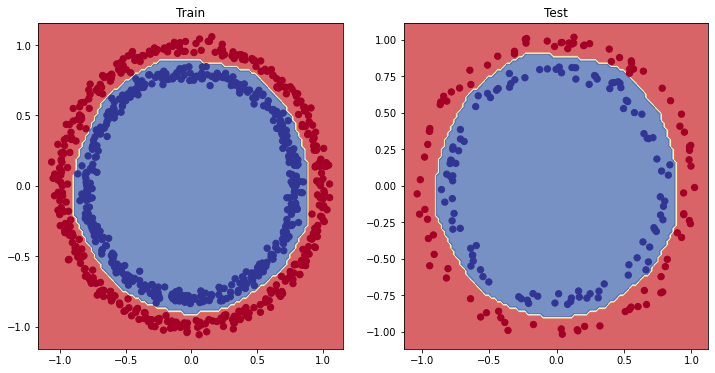

In [85]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(im_model, x_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(im_model, x_test, y_test)